# KKBOX - Análise de Churns

## Instação de Requisitos

In [1]:
!pip install -r ../requirements.txt

INFO: pip is looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.5/238.5 kB 3.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 10.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.2/229.2 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 31.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 6.9 MB/s eta 0:00:00


## Bibliotecas

In [38]:
import pandas_gbq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.oauth2 import service_account

sns.set_style('darkgrid')

Para conectar ao BigQuery, um arquivo de credenciais precisa ser refereciado.

In [3]:
credentials = service_account.Credentials.from_service_account_file('../secrets/gcp_key.json')

## Leitura de Amostras de Dados

Para realizar uma análise inicial dos dados, apenas uma amostra inicial dos dados foi extraída.
- Conjunto de Treino: 100%
- Membros: 20%
- Transações: 5%
- Logs de Usuários: 0.25%

In [4]:
sql = """
    SELECT user_id, c.is_churn
    FROM `cloud-714.mack_churn_gold.goldview`, UNNEST(churn) as c
    WHERE c.month = 2 AND c.year = 2017
"""

train_df = pandas_gbq.read_gbq(sql, credentials=credentials, use_bqstorage_api=True)

/opt/conda/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [6]:
sql = """
    SELECT * EXCEPT(churn, transactions, user_logs)
    FROM `cloud-714.mack_churn_gold.goldview`
    WHERE RAND() < 20/100
"""

members_df = pandas_gbq.read_gbq(sql, credentials=credentials, use_bqstorage_api=True)

/opt/conda/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [8]:
sql = """
    SELECT user_id, t.*
    FROM `cloud-714.mack_churn_gold.goldview`, UNNEST(transactions) AS t
    WHERE RAND() < 5/100
"""

transactions_df = pandas_gbq.read_gbq(sql, credentials=credentials, use_bqstorage_api=True)

/opt/conda/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [10]:
sql = """
    SELECT user_id, u.*
    FROM `cloud-714.mack_churn_gold.goldview`, UNNEST(user_logs) AS u
    WHERE RAND() < 0.25/100
"""

userlogs_df = pandas_gbq.read_gbq(sql, credentials=credentials, use_bqstorage_api=True)

/opt/conda/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


## Análise Exploratória de Dados

Antes de prosseguir para a construção do modelo, vale a pena iniciar com uma análise visual dos dados, onde inicialmente cada conjunto é analizado individualmente, e por fim, os conjuntos de dados são analisados em conjunto para tentar identificar correlações entre algumas variáveis e o churn de um usuário.

### Conjunto de Treino

Text(0.5, 1.0, 'Distribuição de Churn')

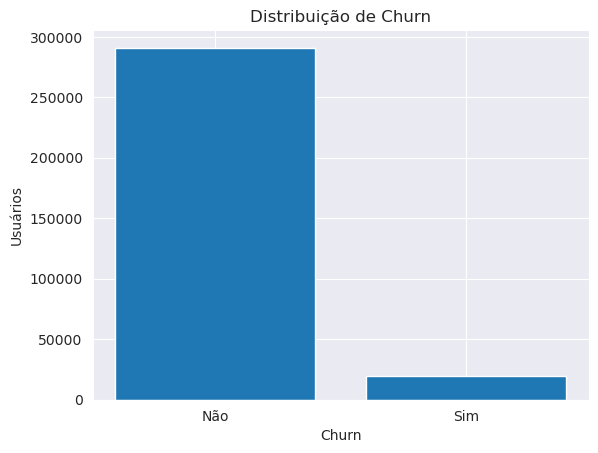

In [246]:
plot_data = train_df['is_churn'].value_counts()
plt.bar(['Não','Sim'],plot_data)
plt.xlabel('Churn')
plt.ylabel('Usuários')
plt.title('Distribuição de Churn')

### Membros

Text(0.5, 1.0, 'Distribuição de Usuário por Método de Registro')

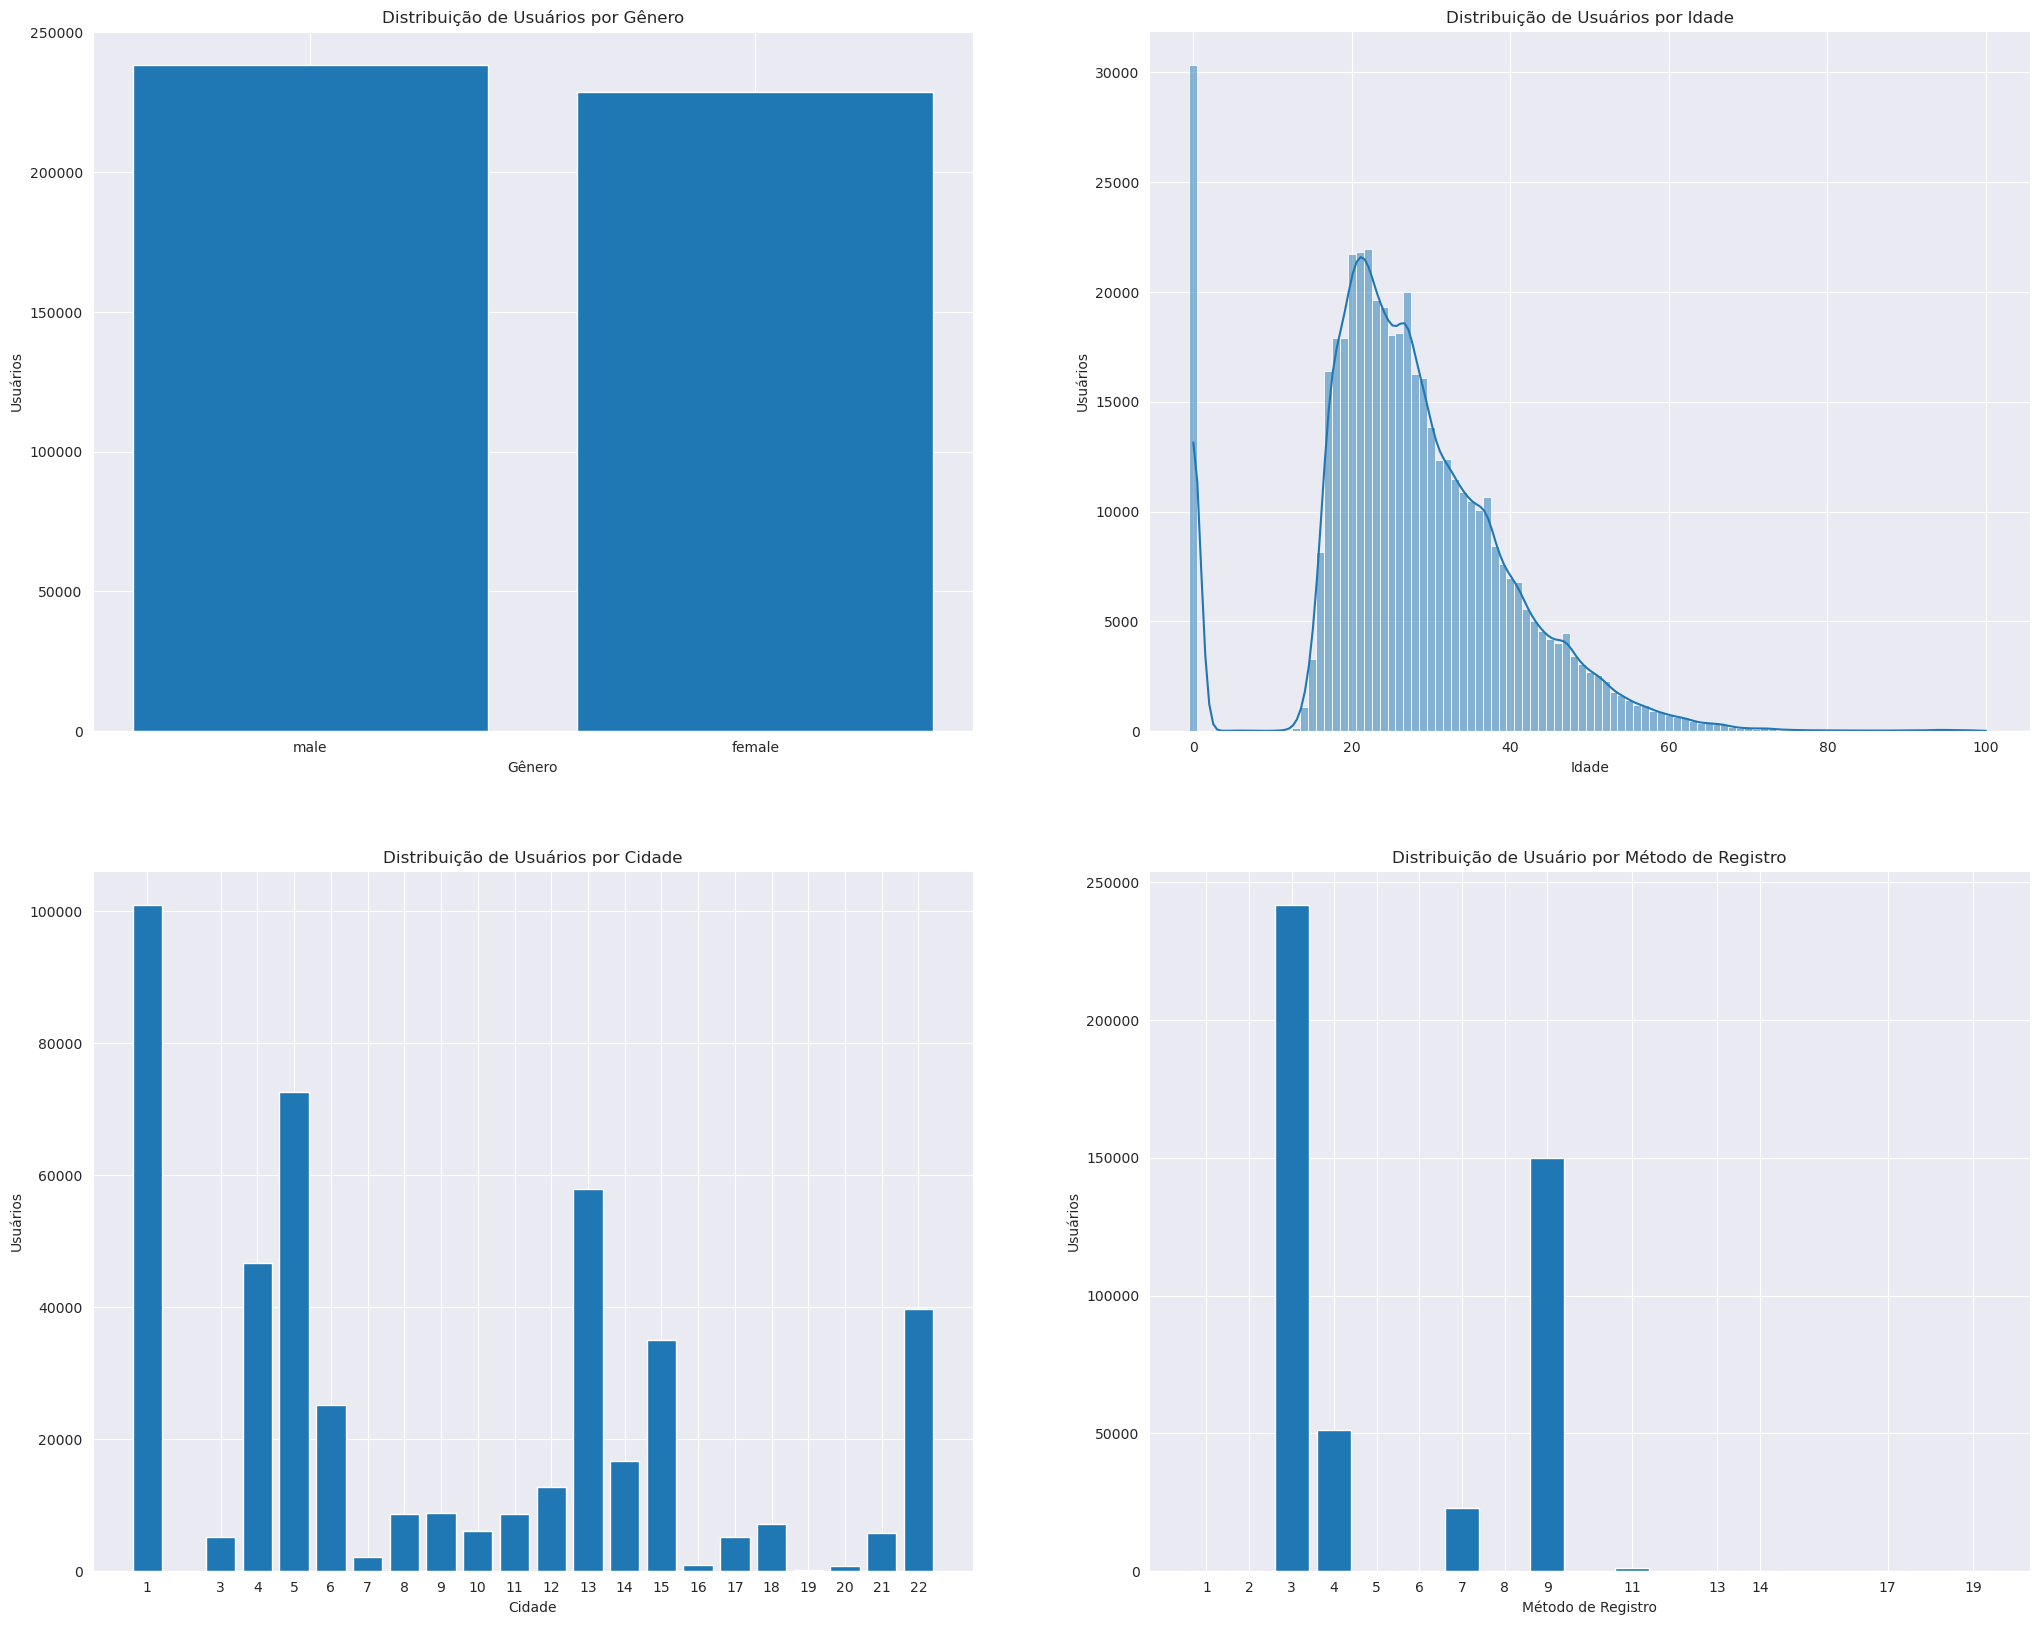

In [247]:
plt.figure(figsize=(25, 20))

plt.subplot(2,2,1)
plot_data = members_df['gender'].value_counts()
plt.bar(plot_data.index, plot_data)
plt.xlabel('Gênero')
plt.ylabel('Usuários')
plt.title('Distribuição de Usuários por Gênero')

plt.subplot(2,2,2)
sns.histplot(members_df['age'], kde = True, discrete=True)
plt.xlabel('Idade')
plt.ylabel('Usuários')
plt.title('Distribuição de Usuários por Idade')

plt.subplot(2,2,3)
plot_data = members_df['city'].value_counts()
plt.bar(plot_data.index, plot_data)
plt.xticks(plot_data.index.tolist())
plt.xlabel('Cidade')
plt.ylabel('Usuários')
plt.title('Distribuição de Usuários por Cidade')

plt.subplot(2,2,4)
plot_data = members_df['registered_via'].value_counts()
plt.bar(plot_data.index, plot_data)
plt.xticks(plot_data.index.tolist())
plt.xlabel('Método de Registro')
plt.ylabel('Usuários')
plt.title('Distribuição de Usuário por Método de Registro')

Text(0, 0.5, 'Registros')

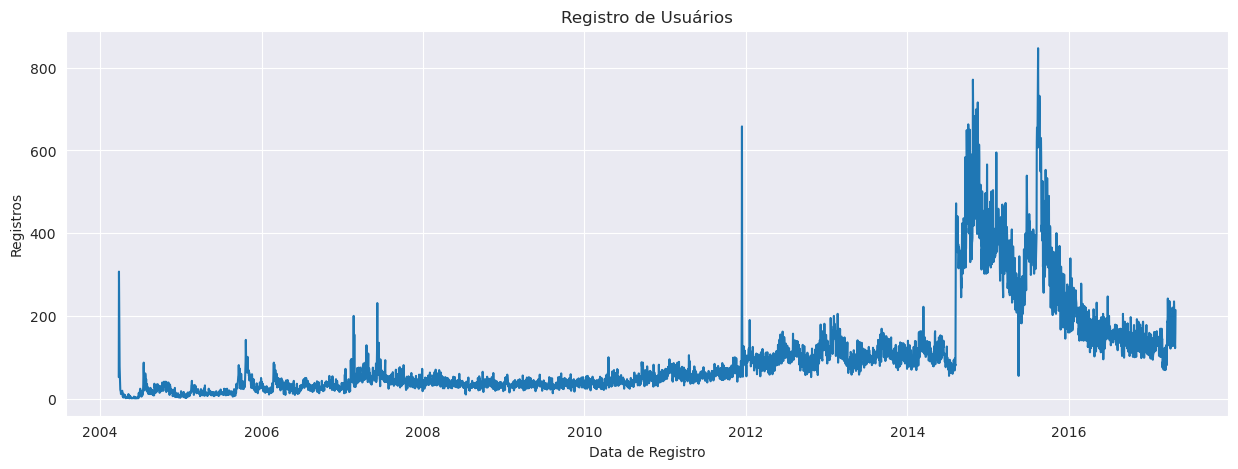

In [248]:
plt.figure(figsize=(15,5))
plot_data = members_df['registration_init_time'].value_counts().reset_index()
sns.lineplot(x="registration_init_time",y="count",data=plot_data)
plt.title('Registro de Usuários')
plt.xlabel('Data de Registro')
plt.ylabel('Registros')

### Logs de Usuários

In [250]:
plot_data = userlogs_df.drop("user_id",axis=1)\
           .groupby("date").sum()\
           .reset_index()\
           .melt(id_vars=["date","total_secs","num_unq"],var_name="quantile",value_name="counts")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


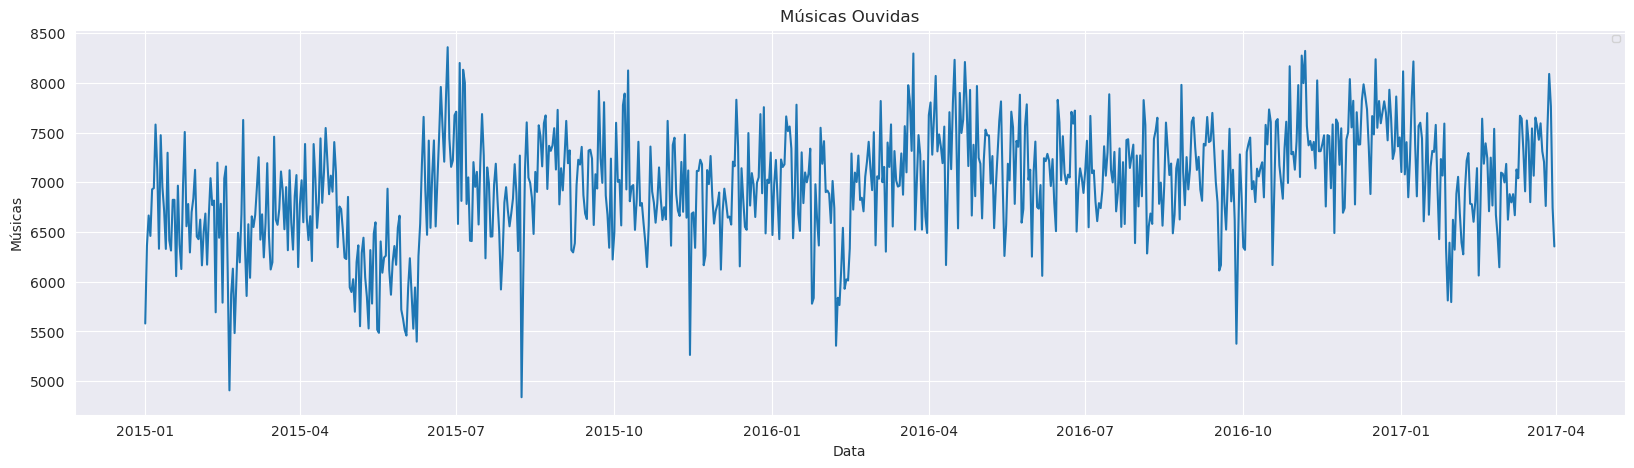

In [251]:
plt.figure(figsize=(20,5))
sns.lineplot(x="date",y="counts",data=plot_data,errorbar=None)
plt.title('Músicas Ouvidas')
plt.xlabel('Data')
plt.ylabel('Músicas')
plt.legend(fontsize=7,loc="upper right")

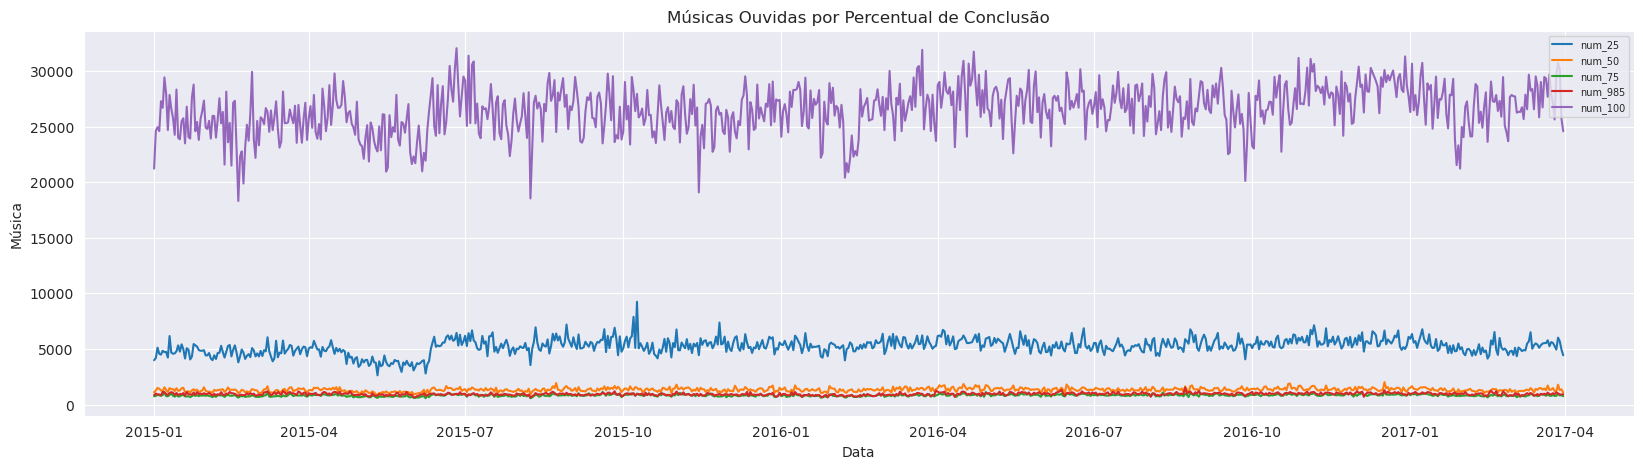

In [252]:
plt.figure(figsize=(20,5))
sns.lineplot(x="date",y="counts",hue="quantile",data=plot_data)
plt.title('Músicas Ouvidas por Percentual de Conclusão')
plt.xlabel('Data')
plt.ylabel('Música')
plt.legend(fontsize=7,loc="upper right")

Text(0.5, 1.0, 'Distribuição de Músicas de Ouvidas por Percentual de Conclusão')

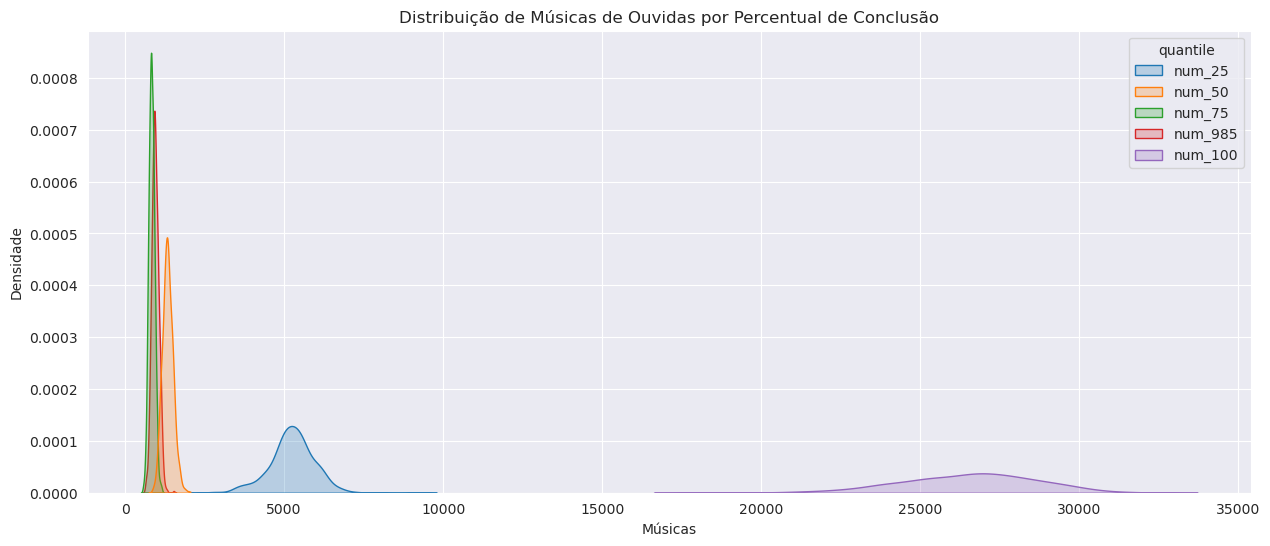

In [253]:
plt.figure(figsize=(15,6))
sns.kdeplot(x="counts", hue="quantile", data=plot_data,fill=True)
plt.xlabel('Músicas')
plt.ylabel('Densidade')
plt.title('Distribuição de Músicas de Ouvidas por Percentual de Conclusão')

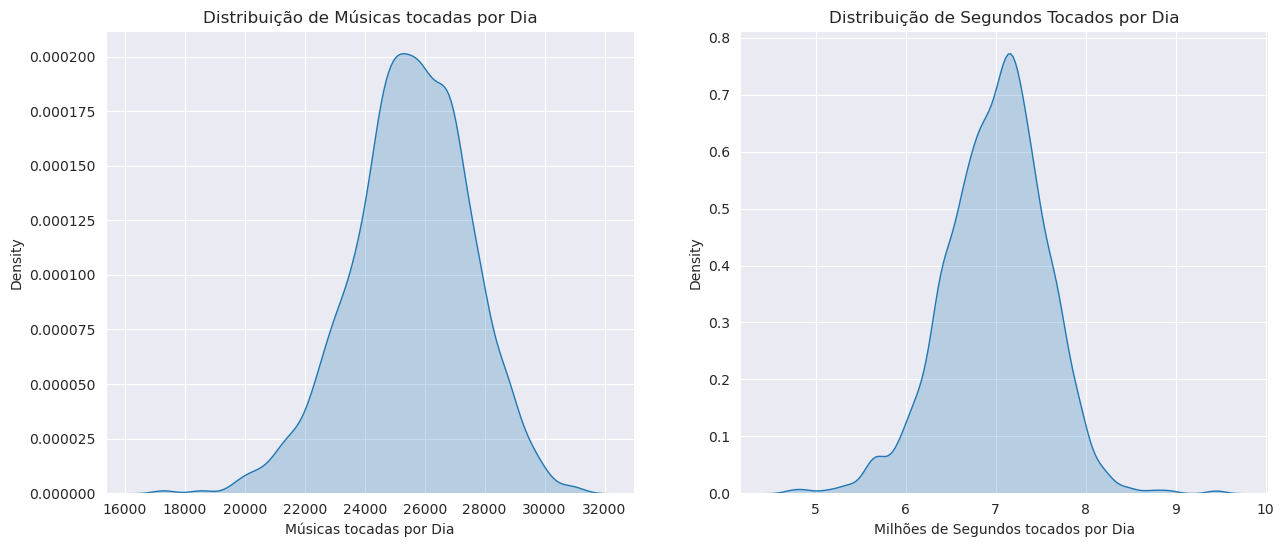

In [255]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.kdeplot(x="num_unq",data=plot_data,fill=True)
plt.title("Distribuição de Músicas tocadas por Dia")
plt.xlabel("Músicas tocadas por Dia")

plt.subplot(1,2,2)
plot_data['total_secs_million'] = plot_data['total_secs']/1000000
sns.kdeplot(x="total_secs_million",data=plot_data,fill=True)
plt.title("Distribuição de Segundos Tocados por Dia")
plt.xlabel("Milhões de Segundos tocados por Dia")
plt.ticklabel_format(style='plain', axis='x')

### Transações

In [20]:
transactions_df

,user_id,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,+/mUb99nNFMD2bAk3UHs+2ArwioKZTZ+e9l3AhWcLh0=,39,30,149,149,True,2016-07-31,2016-09-04,False
1,+0CKhK9/T7WexvYsjWjkPdW93+fTro8IhLueFmamgcM=,35,7,0,0,False,2015-06-02,2015-06-15,False
2,+1zdIyKLVBj91vW/b7CP2RlulptoGgfZlrXjPBAHPfk=,40,31,149,149,True,2015-01-19,2015-02-20,False
3,+1zdIyKLVBj91vW/b7CP2RlulptoGgfZlrXjPBAHPfk=,40,30,149,149,True,2017-02-19,2017-03-20,False
4,+1zdIyKLVBj91vW/b7CP2RlulptoGgfZlrXjPBAHPfk=,40,30,149,149,True,2016-05-19,2016-06-20,False
...,...,...,...,...,...,...,...,...,...
514724,zsamo/aRBcsL/HJukdQnjfHZef/YlQ7DhTjEcgfjQ4s=,30,30,149,149,True,2016-12-01,2016-12-31,False
514725,zuSBlbJwFPN3poGZPOpyGjk4T87J4b97/HVi3j69yNE=,39,30,149,149,True,2015-11-02,2015-12-20,False
514726,zuSBlbJwFPN3poGZPOpyGjk4T87J4b97/HVi3j69yNE=,39,30,149,149,True,2015-07-31,2015-09-20,False
514727,zuSBlbJwFPN3poGZPOpyGjk4T87J4b97/HVi3j69yNE=,39,30,149,149,True,2015-12-02,2016-01-20,False


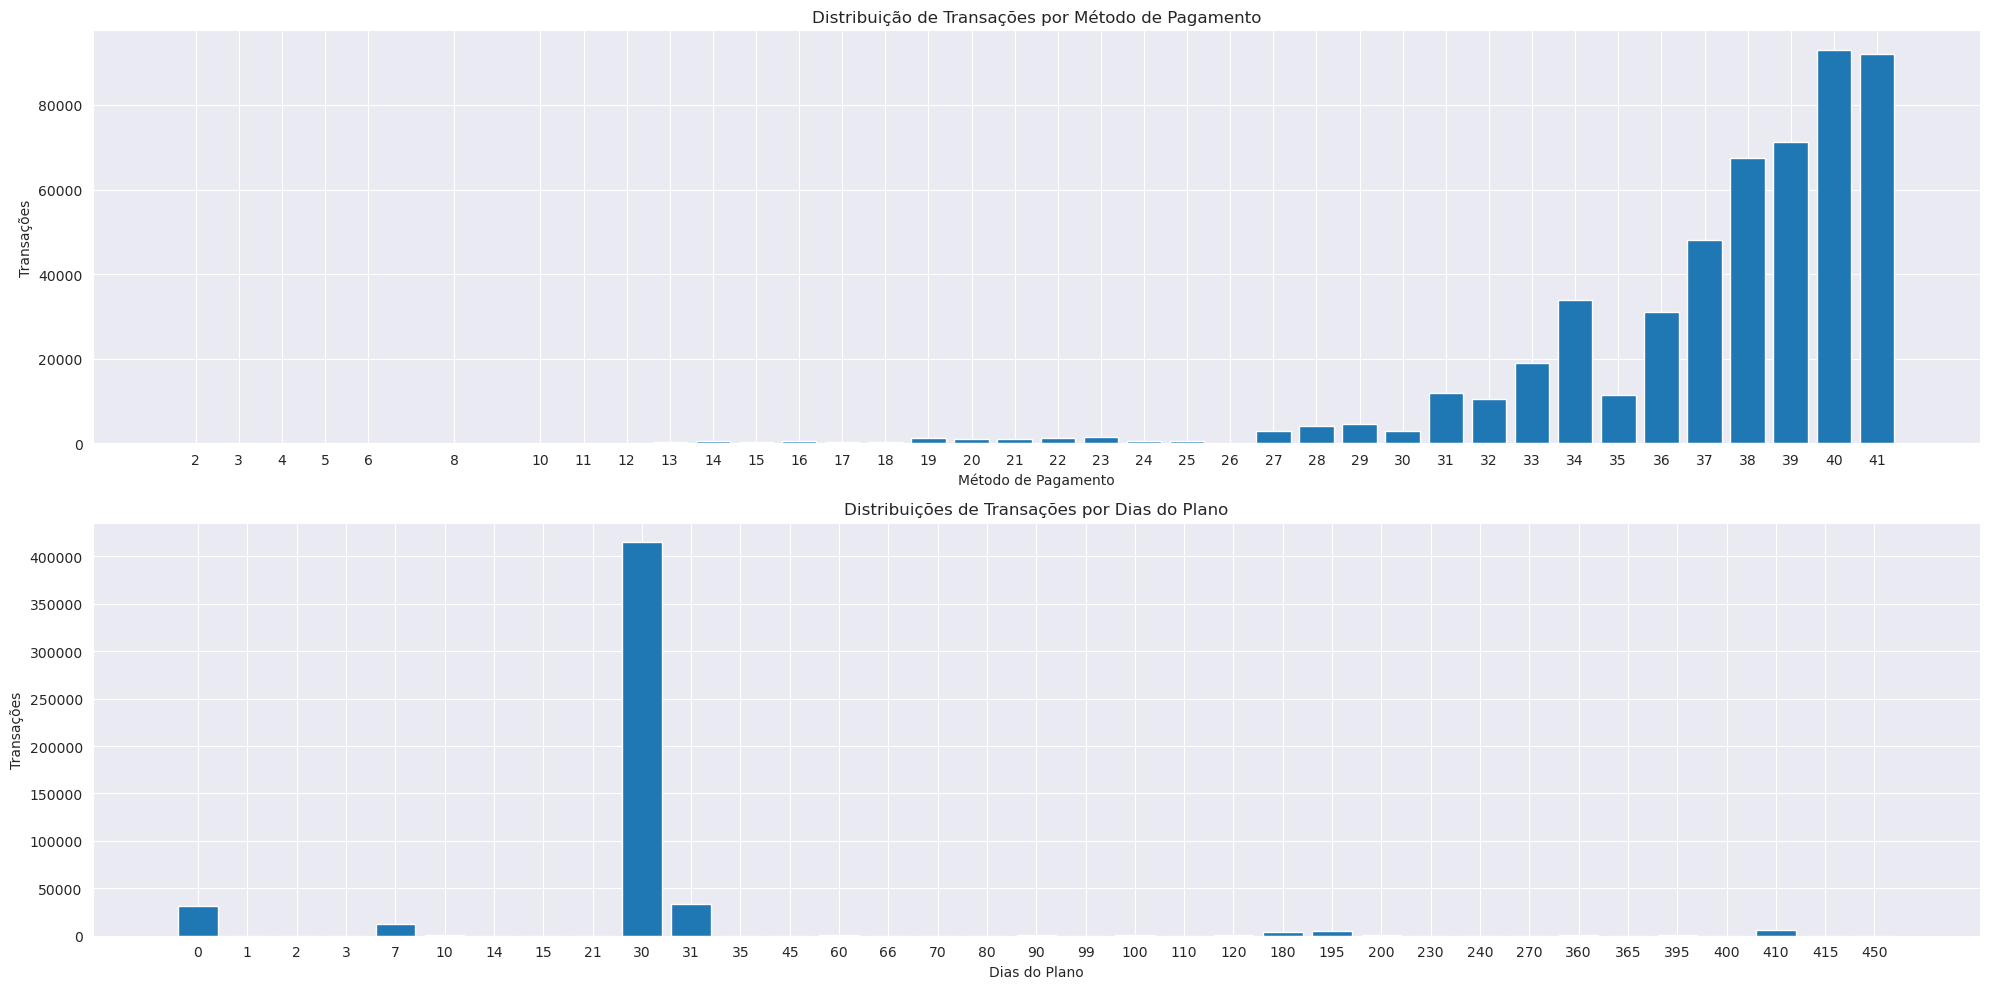

In [256]:
plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plot_data = transactions_df['payment_method_id'].value_counts()
plt.bar(plot_data.index, plot_data)
plt.xlabel('Método de Pagamento')
plt.xticks(plot_data.index.tolist())
plt.ylabel('Transações')
plt.title('Distribuição de Transações por Método de Pagamento')

plt.subplot(2,1,2)
plot_data = transactions_df['payment_plan_days'].value_counts().sort_index()
plt.bar(plot_data.index.astype(str), plot_data)
plt.xlabel('Dias do Plano')
plt.ylabel('Transações')
plt.title('Distribuições de Transações por Dias do Plano')
plt.tight_layout()

In [258]:
plot_data = transactions_df[['actual_amount_paid','transaction_date']].groupby("transaction_date").mean().reset_index()

Text(0, 0.5, 'Valores de Transações')

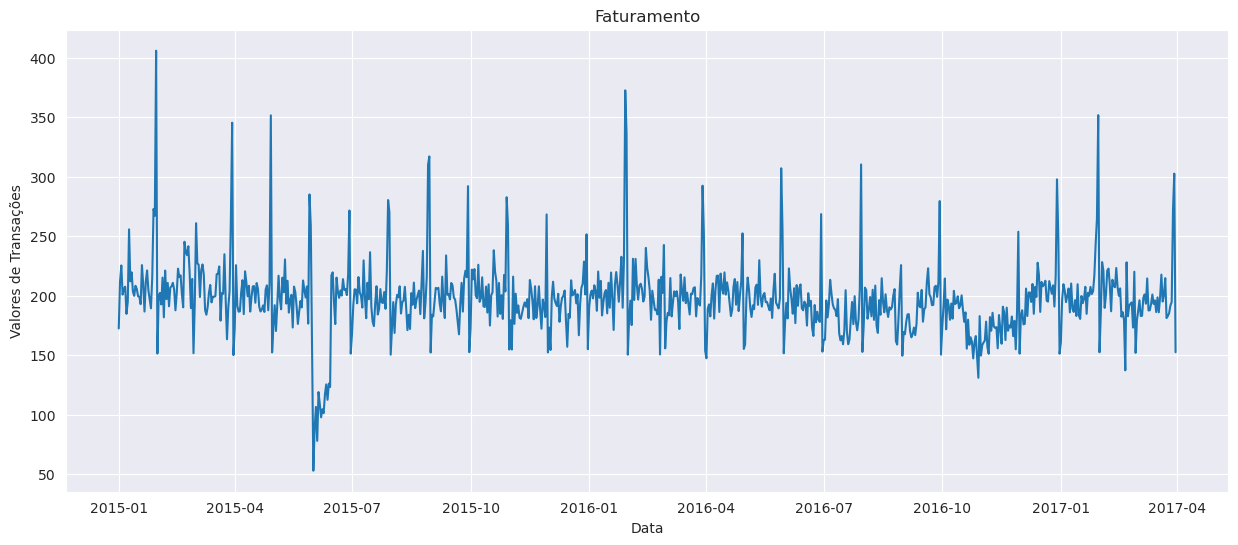

In [259]:
plt.figure(figsize=(15,6))
sns.lineplot(x="transaction_date",y="actual_amount_paid",data=plot_data)
plt.title('Faturamento')
plt.xlabel('Data')
plt.ylabel('Valores de Transações')

In [260]:
plot_data = transactions_df['transaction_date'].value_counts().reset_index()

Text(0, 0.5, 'Transações')

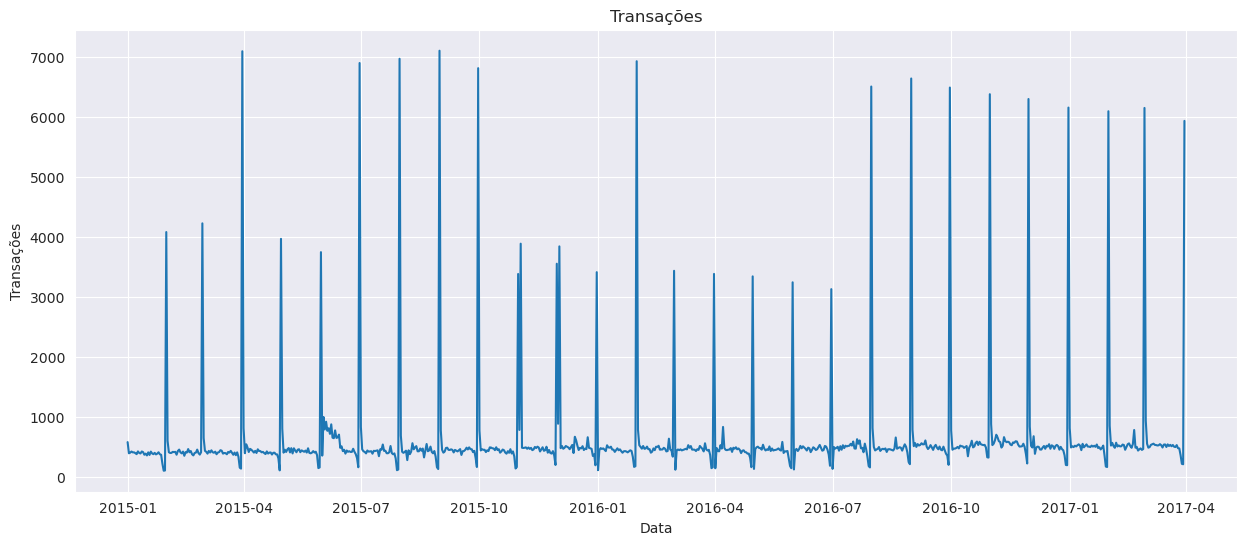

In [261]:
plt.figure(figsize=(15,6))
sns.lineplot(x="transaction_date",y="count",data=plot_data)
plt.title('Transações')
plt.xlabel('Data')
plt.ylabel('Transações')

In [262]:
plot_data['transaction_month'] = pd.DatetimeIndex(plot_data['transaction_date']).month
plot_data['transaction_day_of_week'] = pd.DatetimeIndex(plot_data['transaction_date']).day_name()
plot_data['transaction_day_of_week_number'] = pd.DatetimeIndex(plot_data['transaction_date']).dayofweek
plot_month = plot_data[['transaction_month','count']].groupby('transaction_month').sum().reset_index()
plot_day = plot_data[['transaction_day_of_week','transaction_day_of_week_number','count']].groupby(['transaction_day_of_week','transaction_day_of_week_number']).sum().reset_index().sort_values('transaction_day_of_week_number')

Text(0, 0.5, 'Transações')

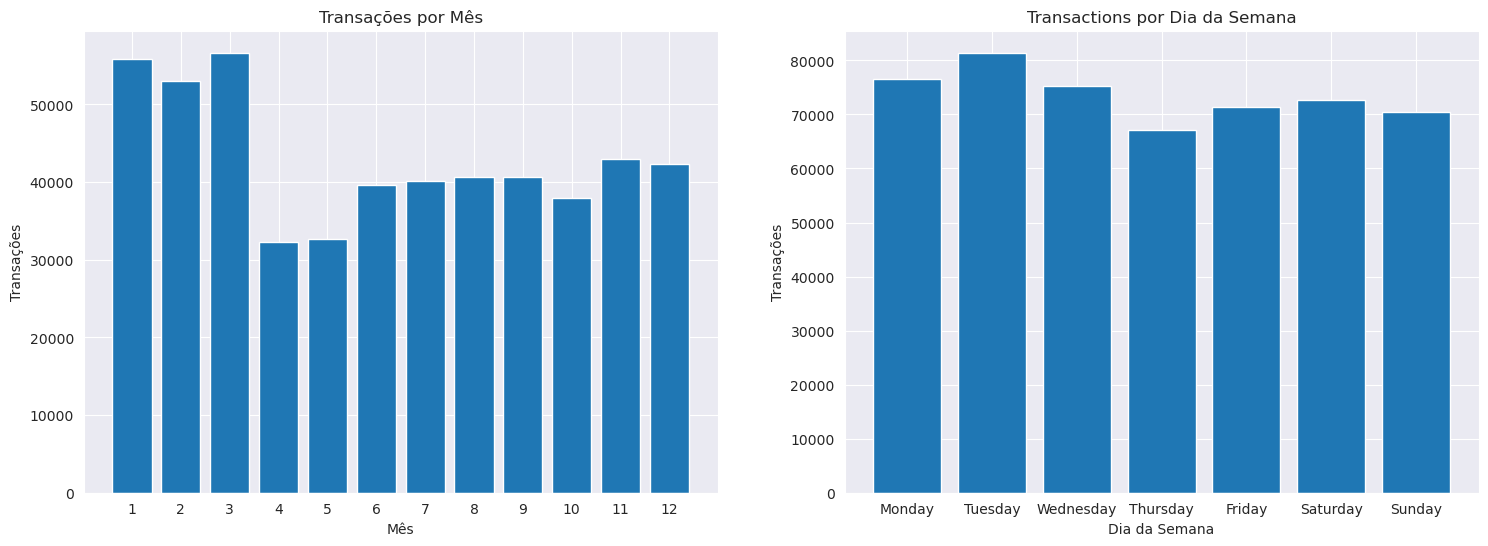

In [263]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.bar(plot_month['transaction_month'],plot_month['count'])
plt.xticks(plot_month['transaction_month'])
plt.title('Transações por Mês')
plt.xlabel('Mês')
plt.ylabel('Transações')

plt.subplot(1,2,2)
plt.bar(plot_day['transaction_day_of_week'],plot_day['count'])
plt.xticks(plot_day['transaction_day_of_week'])
plt.title('Transactions por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Transações')

### Combinações

In [140]:
members_churn_df = members_df.merge(train_df,on='user_id',how='inner')
members_churn_df['registration_init_time'] = pd.to_datetime(plot_data['registration_init_time'])
transactions_churn_df = transactions_df.merge(train_df,on='user_id',how='inner')
userlogs_churn_df = userlogs_df.merge(train_df,on='user_id',how='inner')

#### Algum gênero possui mais tendência ao Churn?

Text(0, 0.5, 'Churns')

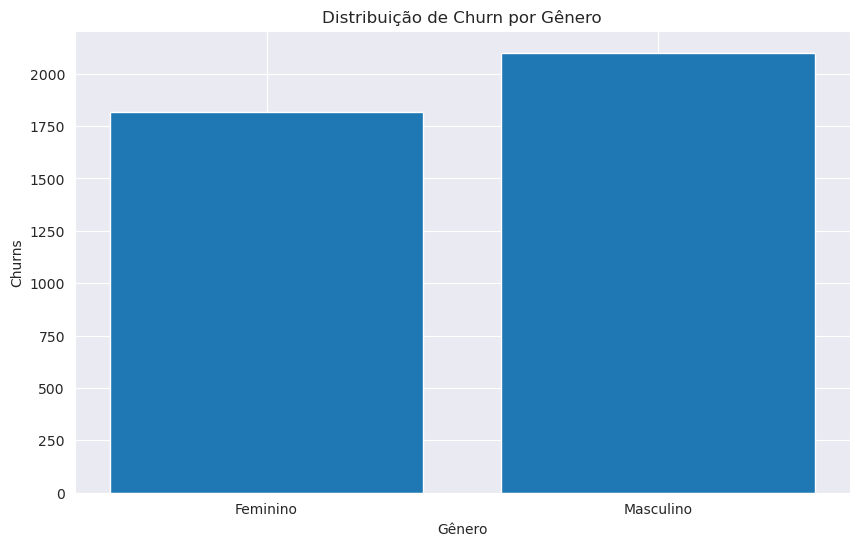

In [265]:
plot_data = members_churn_df[members_churn_df['is_churn'] == True][['gender','is_churn']].groupby('gender').count().reset_index()

plt.figure(figsize=(10,6))
plt.bar(['Feminino','Masculino'],plot_data['is_churn'])
plt.title('Distribuição de Churn por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Churns')

#### Alguma faixa etária possui maior tendência ao Churn?

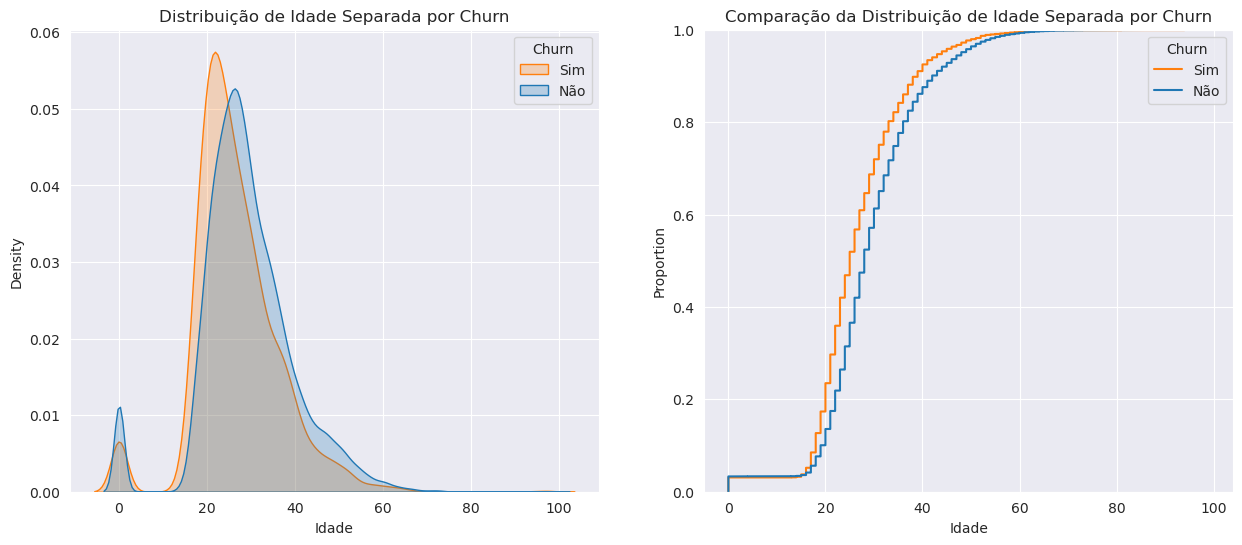

In [280]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plot_data = members_churn_df[['age','is_churn']]
sns.kdeplot(x='age',data=plot_data,hue='is_churn',common_norm=False,fill=True)
plt.title('Distribuição de Idade Separada por Churn')
plt.xlabel('Idade')
plt.legend(labels=['Sim','Não'],title='Churn')

plt.subplot(1,2,2)
sns.ecdfplot(x='age',data=plot_data,hue='is_churn')
plt.title('Comparação da Distribuição de Idade Separada por Churn')
plt.xlabel('Idade')
plt.legend(labels=['Sim','Não'],title='Churn')

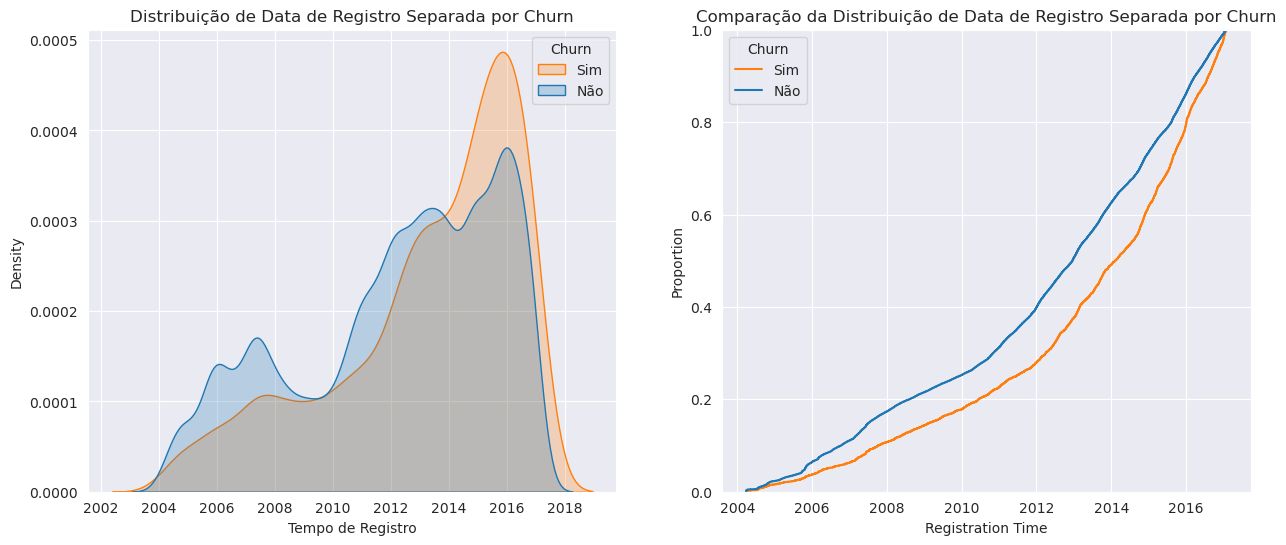

In [282]:
plt.figure(figsize=(15,6))
plot_data = members_churn_df[['registration_init_time','is_churn']]

plt.subplot(1,2,1)
sns.kdeplot(x='registration_init_time',data=plot_data,hue='is_churn',common_norm=False,fill=True)
plt.title('Distribuição de Data de Registro Separada por Churn')
plt.xlabel('Tempo de Registro')
plt.legend(labels=['Sim','Não'],title='Churn')

plt.subplot(1,2,2)
sns.ecdfplot(x='registration_init_time',data=plot_data,hue='is_churn')
plt.title('Comparação da Distribuição de Data de Registro Separada por Churn')
plt.xlabel('Registration Time')
plt.legend(labels=['Sim','Não'],title='Churn')

#### Usuários que escutam mais músicas tem menos tendência ao Churn?

In [115]:
userlogs_churn_df

,user_id,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,is_churn
0,+/jvigyuVWBDBgjIf09lByi6trNgpL2gTfd3xkpQBrE=,2016-05-21,12,0,1,0,4,14,1332.184,False
1,+/jvigyuVWBDBgjIf09lByi6trNgpL2gTfd3xkpQBrE=,2016-05-12,1,3,1,0,27,25,7218.470,False
2,+1ERteypzghW2fKev4UNtV/ixElYil7Ze5ZMKq8nP4I=,2015-01-28,12,11,6,1,11,37,4487.494,False
3,+1ERteypzghW2fKev4UNtV/ixElYil7Ze5ZMKq8nP4I=,2015-03-02,0,1,1,0,15,4,4141.987,False
4,+2XC+l03d/7yhKZMNv2dJFrMMdIve/q0L3hO5wGBWo0=,2016-11-25,22,4,1,2,41,32,11304.060,False
...,...,...,...,...,...,...,...,...,...,...
291763,zeQ8suHi5bnM30CBksFvhTC/owGQLiR5hTLksLhkjsk=,2015-11-13,9,2,2,2,38,11,9684.723,False
291764,zj4H857e9ajkncxEF637o1ZyWPPhrcB9eYvw2VlPlN0=,2016-12-13,3,0,0,0,7,9,1639.151,False
291765,zrZ/8MpgYAee3Z98sa79XQrxWpWlHt72mJvL0jxEWfo=,2015-10-24,0,1,0,0,34,2,9167.980,False
291766,zrZ/8MpgYAee3Z98sa79XQrxWpWlHt72mJvL0jxEWfo=,2016-09-13,2,2,0,0,223,217,56034.888,False


In [283]:
plot_data = userlogs_churn_df.drop('date',axis=1).groupby(['user_id','is_churn']).sum()

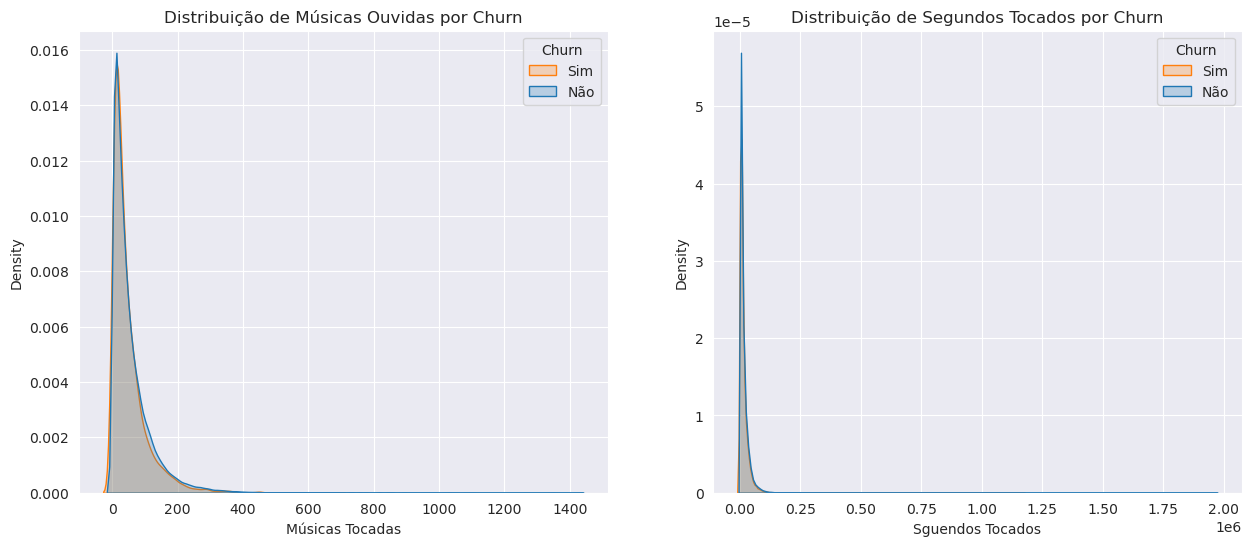

In [284]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.kdeplot(x="num_unq",data=plot_data,hue="is_churn",common_norm=False,fill=True)
plt.title('Distribuição de Músicas Ouvidas por Churn')
plt.xlabel('Músicas Tocadas')
plt.legend(labels=['Sim','Não'],title='Churn')

plt.subplot(1,2,2)
sns.kdeplot(x="total_secs",data=plot_data,hue="is_churn",common_norm=False,fill=True)
plt.title('Distribuição de Segundos Tocados por Churn')
plt.xlabel('Sguendos Tocados')
plt.legend(labels=['Sim','Não'],title='Churn')

In [285]:
renew_data = transactions_churn_df[['user_id','is_auto_renew','is_churn']]
renew_data = renew_data.groupby(['is_auto_renew','is_churn']).nunique().reset_index()
renew_data = renew_data.pivot(values = 'user_id', index = 'is_auto_renew', columns = 'is_churn')
renew_data['%_Churn'] = renew_data[True]/(renew_data[False] + renew_data[True])

cancel_data = transactions_churn_df[['user_id','is_cancel','is_churn']]
cancel_data = cancel_data.groupby(['is_cancel','is_churn']).nunique().reset_index()
cancel_data = cancel_data.pivot(values = 'user_id', index = 'is_cancel', columns = 'is_churn')
cancel_data['%_Churn'] = cancel_data[True]/(cancel_data[False] + cancel_data[True])

Text(0.5, 1.0, 'Percentual de Usuários com Churn com Cancelamentos')

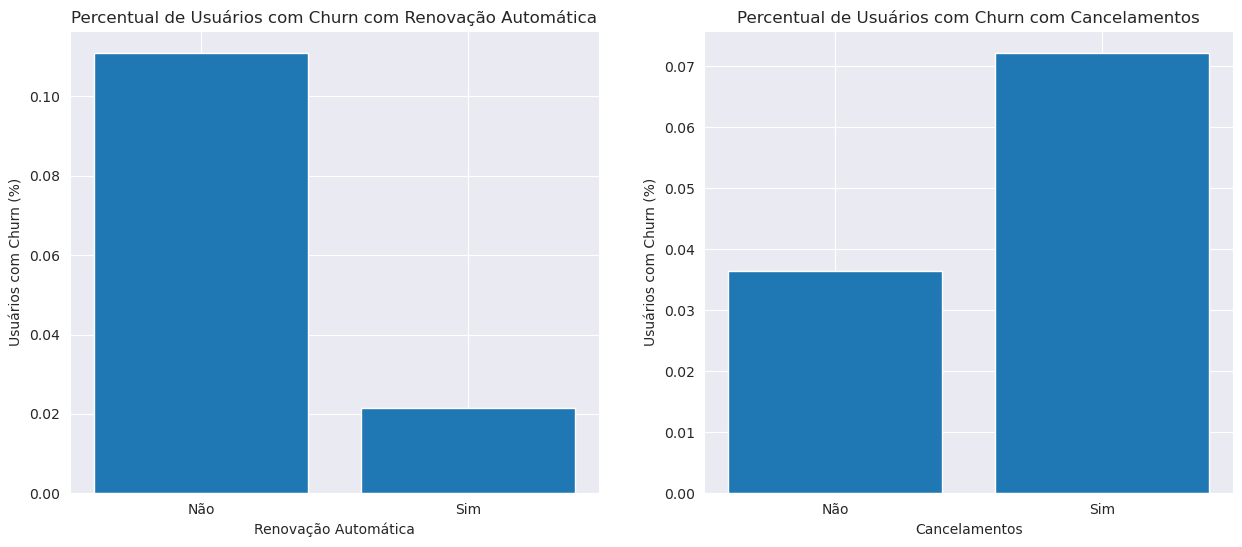

In [287]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.bar(['Não','Sim'],renew_data['%_Churn'])
plt.xlabel('Renovação Automática')
plt.ylabel('Usuários com Churn (%)')
plt.title('Percentual de Usuários com Churn com Renovação Automática')

plt.subplot(1,2,2)
plt.bar(['Não','Sim'],cancel_data['%_Churn'])
plt.xlabel('Cancelamentos')
plt.ylabel('Usuários com Churn (%)')
plt.title('Percentual de Usuários com Churn com Cancelamentos')